# Base forecaster against historical questions

## Imports

In [9]:
from load_secrets import load_secrets
load_secrets()
from forecasting_tools.ai_models.ai_utils.ai_misc import clean_indents

## Historical data

In [2]:
import pandas as pd
df = pd.read_json('resolved.json')

In [3]:
df

,projects_default_project_id,id,open_time,scheduled_resolve_time,title,question_description,question_resolution_criteria,question_fine_print,question_type,question_options,question_group_variable,question_resolution,question_question_weight,question_unit,question_open_upper_bound,question_open_lower_bound,question_scaling_range_max,question_scaling_range_min
0,32721,37220,2025-04-28 10:00:00+00:00,2025-05-17 00:00:00+00:00,How many FBI firearms background checks will i...,In the long term (since the turn of the 21st C...,This question resolves as the number of backgr...,"In case of reporting delays, resolution will w...",numeric,None,,2284806.0,1.0,background checks,1.0,1.0,3100000.0,1800000.0
2,32721,37015,2025-04-22 02:00:00+00:00,2025-05-05 00:00:00+00:00,Will Han Duck-soo announce his candidacy for S...,The Chosun Daily: [Support grows in PPP to dra...,This question resolves as **Yes** if Han Duck-...,,binary,None,,yes,1.0,,0.0,0.0,NaN,NaN
3,32721,37013,2025-04-21 22:00:00+00:00,2025-05-02 00:00:00+00:00,Will the Liberal Democrats win the most seats ...,Cornwall Live: [Cornwall Council elections 202...,This question resolves as **Yes** if the Liber...,,binary,None,,no,1.0,,0.0,0.0,NaN,NaN
4,32721,37012,2025-04-21 20:00:00+00:00,2025-05-02 00:00:00+00:00,Will the Conservative Party win the most seats...,BBC: [A guide to Northamptonshire's local elec...,This question resolves as **Yes** if the Conse...,,binary,None,,no,1.0,,0.0,0.0,NaN,NaN
5,32721,37011,2025-04-21 18:00:00+00:00,2025-05-02 00:00:00+00:00,Will Reform UK win the most seats in the 2025 ...,BBC: ['Unusual' election campaign under way in...,This question resolves as **Yes** if Reform UK...,,binary,None,,yes,1.0,,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,3349,25871,2024-07-08 14:30:00+00:00,2024-07-18 23:52:00+00:00,"On July 17, 2024, will Nvidia's market capital...","Since late 2022, Nvidia Corporation has experi...","This question resolves Yes if, on July 17, 202...",* If Companies Market Cap is unavailable or if...,binary,None,,no,1.0,,NaN,NaN,NaN,NaN
1405,3349,25872,2024-07-08 14:30:00+00:00,2024-07-10 19:31:00+00:00,Will 4 or more goals be scored in the two semi...,The UEFA European championship is a football t...,This question will resolve based on the total ...,,binary,None,,yes,1.0,,NaN,NaN,NaN,NaN
1406,3349,25873,2024-07-08 14:30:00+00:00,2024-09-06 14:02:00+00:00,Will the Real-time Sahm Rule Recession Indicat...,According to [FRED](https://fred.stlouisfed.or...,This question will resolve based on reporting ...,The question will resolve according to the fir...,binary,None,,yes,1.0,,NaN,NaN,NaN,NaN
1407,3349,25874,2024-07-08 14:30:00+00:00,2024-07-23 19:37:00+00:00,Will the time gap between the first and second...,The Tour de France is an annual men's multiple...,This question will resolve based on the time g...,,binary,None,,yes,1.0,,NaN,NaN,NaN,NaN


In [4]:
def load_research(row):
    with open(f"research/{row['id']}.md", 'r') as f:
        return f.read()

In [5]:
df['research'] = df.apply(load_research, axis=1)

In [6]:
df['today'] = df.apply(lambda row: row.open_time.date().strftime("%Y-%m-%d"), axis=1)

## Prompts

### Common

In [7]:
def prompt_all (question):
    return clean_indents(f"""
You are a professional forecaster interviewing for a job.

Your interview question is:
{question.title}

Question background:
{question.question_description}


This question's outcome will be determined by the specific criteria below. These criteria have not yet been satisfied:
{question.question_resolution_criteria}

{question.question_fine_print}

Your research assistant reports:
{question.research}

Today is {question.today}

Before answering you write:
(a) The time left until the outcome to the question is known.
(b) The status quo outcome if nothing changed.""")


### Binary

In [8]:
def prompt_binary(question):
    return clean_indents(prompt_all(question)+
            f"""
(c) A brief description of a scenario that results in a No outcome.
(d) A brief description of a scenario that results in a Yes outcome.

You write your rationale remembering that good forecasters put extra weight on the status quo outcome since the world changes slowly most of the time.

The last thing you write is your final answer as: "Probability: ZZ%", 0-100
            """)

In [ ]:
question_binary = df[df.question_type == 'binary'].iloc[0]
print(prompt_binary(question_binary))

### Multiple Choice

In [ ]:
def prompt_multiple_choice(question):
    return clean_indents(prompt_all(question)+
            f"""
(c) A description of an scenario that results in an unexpected outcome.

You write your rationale remembering that (1) good forecasters put extra weight on the status quo outcome since the world changes slowly most of the time, and (2) good forecasters leave some moderate probability on most options to account for unexpected outcomes.

The last thing you write is your final probabilities for the N options in this order {question.question_options} as:
Option_A: Probability_A
Option_B: Probability_B
...
Option_N: Probability_N""")

In [ ]:
question_multiple_choice = df[df.question_type == 'multiple_choice'].iloc[0]
print(prompt_multiple_choice(question_multiple_choice))

### Numeric question

In [ ]:
import numpy as np

In [ ]:
def _create_upper_and_lower_bound_messages(question):
    if np.isnan(question.question_open_upper_bound):
        upper_bound_message = ""
    else:
        upper_bound_message = (
            f"The outcome can not be higher than {question.question_open_upper_bound}."
        )
    if np.isnan(question.question_open_lower_bound):
        lower_bound_message = ""
    else:
        lower_bound_message = (
            f"The outcome can not be lower than {question.question_open_lower_bound}."
        )
    return upper_bound_message, lower_bound_message

In [ ]:
def prompt_numeric(question):
    upper_bound_message, lower_bound_message = _create_upper_and_lower_bound_messages(question)
    return clean_indents(prompt_all(question)+
    f"""
Units for answer: {question.question_unit if question.question_unit else "Not stated (please infer this)"}

{lower_bound_message}
{upper_bound_message}

Formatting Instructions:
- Please notice the units requested (e.g. whether you represent a number as 1,000,000 or 1 million).
- Never use scientific notation.
- Always start with a smaller number (more negative if negative) and then increase from there

Before answering you write:
(a) The time left until the outcome to the question is known.
(b) The outcome if nothing changed.
(c) The outcome if the current trend continued.
(d) The expectations of experts and markets.
(e) A brief description of an unexpected scenario that results in a low outcome.
(f) A brief description of an unexpected scenario that results in a high outcome.

You remind yourself that good forecasters are humble and set wide 90/10 confidence intervals to account for unknown unknowns.

The last thing you write is your final answer as:
"
Percentile 10: XX
Percentile 20: XX
Percentile 40: XX
Percentile 60: XX
Percentile 80: XX
Percentile 90: XX
" """)

In [ ]:
question_numeric = df[df.question_type == 'numeric'].iloc[0]
print(prompt_numeric(question_numeric))

In [ ]:
prompt_funs = {x: eval(f'prompt_{x}') for x in df.question_type.unique()}
prompt_funs

In [ ]:
def prompt_question(question):
   return (prompt_funs[question.question_type](question)).strip()

In [ ]:
df['prompt'] = df.apply(prompt_question, axis=1)

## Forecast all questions

In [ ]:
question = df.iloc[0]

In [ ]:
prompt = question.prompt

In [ ]:
question.today

In [ ]:
from query_perplexity_with_date_filter import query_perplexity_with_date_filter

In [ ]:
from predict import predict

In [ ]:
import os

In [ ]:
dfn = 'forecast'
os.makedirs(dfn, exist_ok=True)

In [ ]:
from tqdm import tqdm
tqdm.pandas()

In [ ]:
!pwd

In [ ]:
df['forecast'] = df.progress_apply(lambda question: predict(dfn, question), axis=1)

In [ ]:
df.to_json('wow.json')

## Reload all forecasts

In [11]:
df = pd.read_json('wow.json')

## Extract the answer

### Binary

In [12]:
question = df[df.id == 37008].iloc[0]
question

projects_default_project_id                                                 32721
id                                                                          37008
open_time                                                     2025-04-21 12:00:00
scheduled_resolve_time                                        2025-05-01 00:00:00
title                           Will a state of emergency be in effect in Samo...
question_description            [Samoan Prime Minister declares state of emerg...
question_resolution_criteria    This question resolves as **Yes** if, accordin...
question_fine_print             For example, the state of emergency declaratio...
question_type                                                              binary
question_options                                                             None
question_group_variable                                                          
question_resolution                                                            no
question_questio

In [13]:
print(question.forecast)

(a) **Time left until the outcome is known:**  
As of the last information cutoff (April 21, 2025), there were 9 days remaining before April 30, 2025. However, today is May 6, 2025, so the outcome is now in the past and would be known at this point.

(b) **Status quo outcome if nothing changed:**  
The state of emergency (SOE) was officially declared for the island of Upolu on March 31, 2025, set for 30 days and scheduled to expire on April 29, 2025[1][3][4]. As of April 21, 2025, there were no credible reports or government announcements indicating an extension of the SOE beyond this date[1][3]. Therefore, under the status quo, there *would not* be a state of emergency in effect on April 30, 2025.

(c) **Scenario that results in a No outcome:**  
No new Proclamation of Emergency is issued, and the SOE declared on March 31, 2025, expires as scheduled on April 29, 2025. No extensions or additional orders are announced by the Samoan government. As a result, Samoa is not under an SOE on A

In [157]:
import re

def extract_probability(question):
    text = question.forecast
    # Regex to find 'Probability: XX%' or 'Probability: XX'
    text = text.replace('**', '')
    pattern = r"Probability: (\d+)%?"
    match = re.search(pattern, text)
    if match:
        return int(match.group(1))
    return 50

In [158]:
extract_probability(question)

50

In [159]:
question = df[df.id == 35190].iloc[0]
question

projects_default_project_id                                                 32627
id                                                                          35190
open_time                                                     2025-02-19 22:00:00
scheduled_resolve_time                                        2025-04-01 00:00:00
title                           Will any US federal judges be impeached before...
question_description            NewsNation: [Can federal judges be impeached?]...
question_resolution_criteria    This question resolves as **Yes** if a US fede...
question_fine_print             Please note that a conviction in the US Senate...
question_type                                                              binary
question_options                                                             None
question_group_variable                                                          
question_resolution                                                            no
question_questio

In [160]:
question = df[df.id == 36168].iloc[0]

In [161]:
extract_probability(question)

50

### Numeric

In [16]:
import re

def extract_percentiles0(question):
    text = question.forecast
    # Regex to find lines like 'Percentile X: number'
    pattern = r"Percentile (\d+): ([\d,]+)"
    matches = re.findall(pattern, text)
    # Convert to dict with integer keys and values (remove commas)
    percentiles = {int(p): int(v.replace(',', '')) for p, v in matches}
    return percentiles

In [17]:
import re

def extract_percentiles1(question):
    text = question.forecast
    # Regex to capture "Percentile X: [expression]" with flexible whitespace and special chars
    pattern = r"Percentile\s*(\d+):\s*([^\n]+)"
    matches = re.findall(pattern, text)
    
    # Clean and store expressions (remove markdown, extra spaces)
    percentiles = {}
    for p, expr in matches:
        p = int(p)
        # Remove common noise characters: *,_ and trim whitespace
        clean_expr = re.sub(r"[*_-]", "", expr).strip()
        percentiles[p] = clean_expr
    
    return percentiles

In [18]:
def extract_percentiles2(question):
    text = question.forecast
    # Regex to capture percentage AFTER '+' and before '%', ignoring other numbers
    pattern = r"Percentile\s*(\d+):\s*.*?([+-]\s*)?(\d*\.?\d+)%"
    matches = re.findall(pattern, text)
    # Extract percentile and percentage value (ignore operator like '+')
    percentiles = {int(p): float(percent) for p, _, percent in matches}
    return percentiles

In [19]:
def extract_percentiles3(question):
    text = question.forecast
    # Regex handles commas and variable whitespace
    pattern = r"Percentile\s*(\d+):\s*([\d,]+)"
    matches = re.findall(pattern, text)
    return {int(p): int(v.replace(',', '')) for p, v in matches}

In [20]:
import re

def extract_percentiles4(question):
    text = question.forecast
    # Regex to capture percentile lines with flexible formatting
    pattern = r"Percentile\s*(\d+):\s*([^\n]+)"
    matches = re.findall(pattern, text)
    
    percentiles = {}
    for p, val_str in matches:
        p = int(p)
        val_str = val_str.strip()
        
        # Check for percentage format (e.g., "S₀ + 0.5%")
        if '%' in val_str:
            pct_match = re.search(r"(\d+\.?\d+)%", val_str.replace(',', ''))
            if pct_match:
                percentiles[p] = float(pct_match.group(1))
        # Check for absolute numeric format (e.g., "1,600,000")
        else:
            num_match = re.search(r"[\d,]+", val_str)
            if num_match:
                percentiles[p] = int(num_match.group(0).replace(',', ''))
                
    return percentiles


In [21]:
def linear_sample_percentiles(range_min, range_max):
    percentiles = [10, 20, 40, 80, 90]
    fractions = [p / 100 for p in percentiles]
    samples = {int(f*100): range_min + f * (range_max - range_min) for f in fractions}
    return samples

In [34]:
def extract_percentiles1(question):
    text = question.forecast
    return linear_sample_percentiles(question.question_scaling_range_max, question.question_scaling_range_min)

In [44]:
def extract_percentiles(question):
    tries = [f(question) for f in [extract_percentiles0, extract_percentiles3]]
    lengths = [len(x) for x in tries]
    maxlength = max(lengths)
    if maxlength > 0:
        for x in tries:
            if len(x) == maxlength:
                return x
    return extract_percentiles1(question)

In [46]:
question = df[df.id == 36164].iloc[0]

In [47]:
extract_percentiles(question)

{10: 118000.0, 20: 116000.0, 40: 112000.0, 80: 104000.0, 90: 102000.0}

In [48]:
question = df.iloc[0]

In [49]:
extract_percentiles(question)

{10: 1600000, 20: 1700000, 40: 1850000, 60: 1950000, 80: 2100000, 90: 2200000}

In [50]:
print(df.iloc[0].question_resolution)

2284806.0


In [51]:
question = df[df.id == 35678].iloc[0]

In [53]:
extract_percentiles(question)

{10: 11405000.0, 20: 11010000.0, 40: 10220000.0, 80: 8640000.0, 90: 8245000.0}

### Multiple choice

In [83]:
question = df[df.question_type == 'multiple_choice'].iloc[0]

In [84]:
import re

def extract_probabilities(text, question_options, prefix='Option_[A-Z]:'):
    # Regex to capture "Option_X: [label]: [percentage]%"
    pattern = prefix + r"\s*([^:]+?)\s*:\s*\**(\d+)%\**"
    matches = re.findall(pattern, text)
    
    # Convert to dictionary with percentage values
    prob_map = {}
    for label, pct_str in matches:
        label = label.strip()
        if label in question_options:
            prob_map[label] = int(pct_str) / 100.0
    
    # Ensure all question options are in the map (0% if missing)
    for option in question_options:
        if option not in prob_map:
            prob_map[option] = 0.0
    
    return prob_map

In [85]:
print(question.forecast)

(a) **Time left until outcome**: 11 days (March 20 → March 31, 2025)  
(b) **Status quo outcome**: Call Her Daddy remains above Candace, as their current ranks (#4 vs. #5) and stability metrics suggest no imminent reversal absent new developments[1][3].  
(c) **Unexpected outcome scenario**: A viral Candace episode (e.g., high-profile political endorsement or controversy) could spike downloads, while Call Her Daddy’s relative lack of recent news leaves it vulnerable to stagnation[1][5].  

### Rationale  
1. **Stability of top podcasts**: Established shows in the 4-5 range rarely swap positions without specific catalysts (new episodes, media coverage, or algorithm changes)[3].  
2. **Candace’s upward trajectory**: Despite its #5 rank, Candace Owens’ podcast has demonstrated rapid growth since its June 2024 launch, suggesting underlying momentum[1][2].  
3. **Call Her Daddy’s advantage**: The show’s $30M+ brand value and consistent topical relevance (dating/relationships) provide a defe

In [86]:
question.question_options

"['Call Her Daddy', 'Candace']"

In [87]:
question.question_resolution

'Candace'

In [90]:
text, question_options = question.forecast, eval(question.question_options)

In [92]:
extract_probabilities(text, question_options, '')

{'Call Her Daddy': 0.65, 'Candace': 0.35}

In [94]:
def extract_multiple_choice(question):
    text, question_options = question.forecast, eval(question.question_options)
    if 'Option_' in text:
        return extract_probabilities(text, question_options)
    else:
        return extract_probabilities(text, question_options, '')

In [95]:
question = df[df.id == 36264].iloc[0]

In [96]:
print(question.forecast)

(a) **Time left until outcome**: 11 days (March 20 → March 31, 2025)  
(b) **Status quo outcome**: Call Her Daddy remains above Candace, as their current ranks (#4 vs. #5) and stability metrics suggest no imminent reversal absent new developments[1][3].  
(c) **Unexpected outcome scenario**: A viral Candace episode (e.g., high-profile political endorsement or controversy) could spike downloads, while Call Her Daddy’s relative lack of recent news leaves it vulnerable to stagnation[1][5].  

### Rationale  
1. **Stability of top podcasts**: Established shows in the 4-5 range rarely swap positions without specific catalysts (new episodes, media coverage, or algorithm changes)[3].  
2. **Candace’s upward trajectory**: Despite its #5 rank, Candace Owens’ podcast has demonstrated rapid growth since its June 2024 launch, suggesting underlying momentum[1][2].  
3. **Call Her Daddy’s advantage**: The show’s $30M+ brand value and consistent topical relevance (dating/relationships) provide a defe

In [97]:
print(question.question_options)

['Call Her Daddy', 'Candace']


In [98]:
extract_multiple_choice(question)

{'Call Her Daddy': 0.65, 'Candace': 0.35}

In [153]:
question = df[df.id == 36168].iloc[0]

In [154]:
extract_multiple_choice(question)

{'Under 10,000': 0.1,
 '10,000-11,000': 0.15,
 '>11,000 and <12,000': 0.2,
 '12,000 to 14,000': 0.4,
 'Over 14,000': 0.15}

In [101]:
question.question_options

"['Under 10,000', '10,000-11,000', '>11,000 and <12,000', '12,000 to 14,000', 'Over 14,000']"

In [102]:
print(question.forecast)

(a) **Time until outcome is known:**  
The March 2025 arrival data from the UNHCR Mediterranean Refugees/Migrants Data Portal is typically published in the first week of April 2025. Given today is May 6, 2025, the data should already be available, but as of March 19, 2025 (the scenario date), about two to three weeks remained until official figures would be published[1].

(b) **Status quo outcome if nothing changes:**  
In January–February 2025, there were a total of nearly 25,000 irregular border crossings into the EU, averaging about 12,500 per month[1][5]. The Central Mediterranean route continues to see higher arrivals, while other routes are experiencing declines. March arrivals typically increase with spring weather, but the policy environment remains restrictive. If current patterns persist without major shocks, the likely number of Mediterranean arrivals (sea and land) for March 2025 would be in the **12,000 to 14,000** range[1][5].

(c) **Scenario leading to an unexpected outc

In [103]:
extract_multiple_choice(question)

{'Under 10,000': 0.1,
 '10,000-11,000': 0.15,
 '>11,000 and <12,000': 0.2,
 '12,000 to 14,000': 0.4,
 'Over 14,000': 0.15}

### All

In [104]:
def extract_forecast(question):
    method = {'binary': extract_probability,
              'numeric': extract_percentiles,
              'multiple_choice': extract_multiple_choice}
    return method[question.question_type](question)

In [162]:
df['prediction'] = df.apply(extract_forecast, axis=1)

In [163]:
df.to_json('run_with_predictions.json')

## Scoring rule

### Binary

In [109]:
df[df.question_type == 'binary'].question_resolution.unique()

array(['yes', 'no'], dtype=object)

In [110]:
question = df[df.question_type == 'binary'].iloc[0]

In [166]:
question = df[df.id == 35190].iloc[0]
question

projects_default_project_id                                                 32627
id                                                                          35190
open_time                                                     2025-02-19 22:00:00
scheduled_resolve_time                                        2025-04-01 00:00:00
title                           Will any US federal judges be impeached before...
question_description            NewsNation: [Can federal judges be impeached?]...
question_resolution_criteria    This question resolves as **Yes** if a US fede...
question_fine_print             Please note that a conviction in the US Senate...
question_type                                                              binary
question_options                                                             None
question_group_variable                                                          
question_resolution                                                            no
question_questio

In [167]:
question.question_resolution, question.prediction

('no', 50)

In [168]:
def calculate_ubs_binary(instance):
    """
    Calculate Universal Binarized Score (UBS) for a binary question forecast.
    
    Args:
        instance: Object with:
            - prediction (int/float): Forecast probability for 'yes' (0-100)
            - question_resolution (str): Actual outcome ('yes' or 'no')
    
    Returns:
        float: UBS score between 0 (worst) and 1 (best)
    """
    # Convert prediction to probability (0.0-1.0 scale)
    p_yes = instance.prediction / 100.0
    p_no = 1.0 - p_yes
    
    # Convert resolution to binary (1.0 for 'yes', 0.0 for 'no')
    resolution = instance.question_resolution.lower()
    y_yes = 1.0 if resolution == 'yes' else 0.0
    y_no = 1.0 - y_yes
    
    # Calculate Brier Score (sum of squared errors for both outcomes)
    brier_score = (p_yes - y_yes)**2 + (p_no - y_no)**2
    
    # Universal Binarized Score (UBS)
    K_max = 2.0  # Maximum possible Brier Score for binary questions
    ubs = 1.0 - (brier_score / K_max)
    
    return round(ubs, 4)  # Rounded to 4 decimal places for readability


In [115]:
calculate_ubs_binary(question)

0.99

### Numeric

In [116]:
def calculate_ubs_numeric(instance):
    """
    Calculate Universal Binarized Score (UBS) for numeric forecasts using CRPS.
    
    Args:
        instance: Object with:
            - prediction (dict): Percentile-to-value mapping (e.g., {10: 1600000, ...})
            - question_resolution (float): Actual resolved value
    
    Returns:
        float: UBS score between 0 (worst) and 1 (best)
    """
    percentiles = sorted(instance.prediction.keys())
    values = [float(instance.prediction[p]) for p in percentiles]
    if instance.question_resolution == "below_lower_bound":
        Q = instance.question_scaling_range_min
    elif instance.question_resolution == "above_upper_bound":
        Q = instance.question_scaling_range_max
    else:
        Q = float(instance.question_resolution)
    min_val, max_val = values[0], values[-1]
    
    # Linear interpolation for CDF
    def cdf(x):
        if x <= min_val: return 0.0
        if x >= max_val: return 1.0
        for i in range(len(values)-1):
            if values[i] <= x < values[i+1]:
                p_low = percentiles[i]/100
                p_high = percentiles[i+1]/100
                return p_low + (x - values[i]) * (p_high - p_low)/(values[i+1] - values[i])
        return 0.0
    
    # CRPS calculation
    crps = 0.0
    for i in range(len(values)-1):
        v1, v2 = values[i], values[i+1]
        mid = (v1 + v2)/2
        F_mid = cdf(mid)
        I_mid = 1.0 if mid >= Q else 0.0
        crps += (F_mid - I_mid)**2 * (v2 - v1)
        
    # Tail contributions
    if Q < min_val:
        crps += (0.0 - 1.0)**2 * (min_val - Q)
    elif Q > max_val:
        crps += (1.0 - 0.0)**2 * (Q - max_val)
    
    # Normalize using question's intrinsic range
    K_max = max_val - min_val
    ubs = 1.0 - (crps / K_max) if K_max != 0 else 0.0
    return max(0.0, min(1.0, round(ubs, 4)))

In [117]:
question=df[df.id==35677].iloc[0]

In [118]:
print(question.forecast)

(a) **Time left until outcome is known:**  
The outcome—total Bay Wheels trips for February 2025—will be published after February closes. Since today is May 6, 2025, and the BTS data is typically updated with a lag, the number is now likely available or will be within days.

(b) **Status quo outcome if nothing changed:**  
If ridership stayed at its February 2024 level (preliminary, as current detailed monthly numbers were not in the search results but inferred from trends), the number of trips would be slightly lower than February 2025's likely outcome, since ridership has increased year-over-year[3].

(c) **Outcome if current trend continued:**  
Ridership across the first nine months of 2024 set all-time highs compared to the same period in prior years[3]. E-bike growth and network expansion continue to boost usage, so if this trend persists, February 2025 should reach or slightly surpass the February 2024 figure. Given that every month since mid-2023 has equaled or exceeded its 201

In [119]:
question.prediction

{10: 230000, 20: 250000, 40: 270000, 60: 290000, 80: 320000, 90: 340000}

In [120]:
calculate_ubs_numeric(question)

0.9055

In [121]:
question = df[df.question_type == 'numeric'].iloc[0]

In [122]:
question

projects_default_project_id                                                 32721
id                                                                          37220
open_time                                                     2025-04-28 10:00:00
scheduled_resolve_time                                        2025-05-17 00:00:00
title                           How many FBI firearms background checks will i...
question_description            In the long term (since the turn of the 21st C...
question_resolution_criteria    This question resolves as the number of backgr...
question_fine_print             In case of reporting delays, resolution will w...
question_type                                                             numeric
question_options                                                             None
question_group_variable                                                          
question_resolution                                                     2284806.0
question_questio

In [123]:
print(question.question_resolution)

2284806.0


In [124]:
calculate_ubs_numeric(question)

0.5478

### Multiple choice

In [125]:
question = df[df.question_type == 'multiple_choice'].iloc[0]

In [126]:
question

projects_default_project_id                                                 32627
id                                                                          36264
open_time                                                     2025-03-20 18:00:00
scheduled_resolve_time                                        2025-03-31 00:00:00
title                           Which podcast will be ranked higher on Spotify...
question_description            At the time of this question, Candace is ranke...
question_resolution_criteria    This question resolves as the podcast with the...
question_fine_print             Ensure settings are on United States and Top P...
question_type                                                     multiple_choice
question_options                                    ['Call Her Daddy', 'Candace']
question_group_variable                                                      Rank
question_resolution                                                       Candace
question_questio

In [127]:
question.prediction, question.question_resolution

({'Call Her Daddy': 0.65, 'Candace': 0.35}, 'Candace')

In [128]:
def calculate_ubs_multiclass(instance):
    """
    Calculate Universal Binarized Score (UBS) for a multi-category question.
    
    Args:
        instance: Object with:
            - prediction (dict): {category: percentage forecast (0-100)}
            - question_resolution (str): The correct category
    
    Returns:
        float: UBS score between 0 (worst) and 1 (best)
    """
    categories = list(instance.prediction.keys())
    n = len(categories)
    # Convert predictions to probabilities (0.0-1.0)
    probs = {k: instance.prediction[k]/100.0 for k in categories}
    # Create outcome vector: 1 for correct, 0 for others
    outcome = {k: 1.0 if k == instance.question_resolution else 0.0 for k in categories}
    # Multi-category Brier score
    brier = sum((probs[k] - outcome[k])**2 for k in categories)
    # Normalize by maximum possible score (which is n)
    ubs = 1.0 - (brier / n)
    return max(0.0, min(1.0, round(ubs, 4)))

In [129]:
calculate_ubs_multiclass(question)

0.5035

In [130]:
question = df[df.id == 36168].iloc[0]

In [131]:
calculate_ubs_multiclass(question)

0.8004

### All

In [170]:
def calculate_ubs(question):
    method = {'binary': calculate_ubs_binary,
              'numeric': calculate_ubs_numeric,
              'multiple_choice': calculate_ubs_multiclass}
    return method[question.question_type](question)

In [171]:
df['score'] = df.apply(calculate_ubs, axis=1)

In [172]:
df.to_json('scored.json')

## Explore performance a little

In [175]:
%matplotlib inline

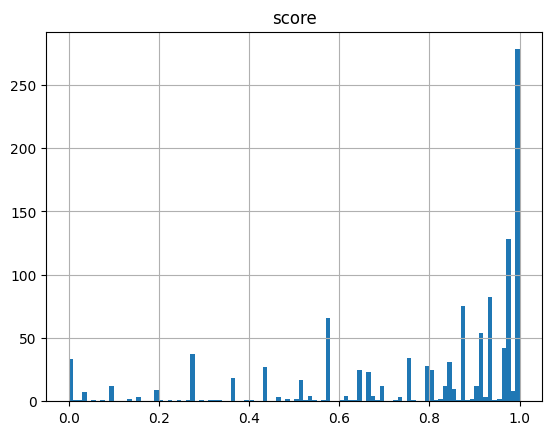

In [180]:
import matplotlib.pyplot as plt

ax = df.hist(column='score', bins=100)
plt.show()  # explicitly show the plot

## Make it more RAGy, using the references in the prompt for possible deeper search

In [ ]:
df[df.id == 36164].iloc[0]